# 2D Flow Past a Cylinder (Isothermal Lattice-Boltzmann)

In this notebook we will numerically investigate the behavior of 2D fluids without directly solving the Navier-Stokes equations. The alternative method we explore involves a 'density' that is iterated over alternating _streaming_ and _collision_ processes that transport and relax its values over the lattice. 

On a nodal level, we choose a scheme ($\cal{D2Q9}$) where any particular lattice site has the following structure:

<p style="text-align:center;"><img src = "9bolt.jpg" alt = 'D2Q9 Cell' width = '300' height = '300'></p>

Each central node has 
- 9 connections:
    - 1 connection to itself (velocity 0).
    - 4 connections to nodes along the cardinal directions (velocity 1).
    - 4 connections to nodes along the inter-cardinal directions (velocity 1).

Each node has an associated weight $w_{i}$, which we will return to shortly.

The fluid is composed of microscopic particles with a by a phase-space density specified by the distribution function $f = f(\mathbf{r},\mathbf{v})$. Restricting particles to stream and collide manifests the [BGK approximation](https://en.wikipedia.org/wiki/Bhatnagar%E2%80%93Gross%E2%80%93Krook_operator):

$$
    \frac{\partial f}{\partial t} 
    + \underbrace{(\mathbf{v}\cdot\nabla)f}_{\textrm{Streaming}} 
    + \underbrace{\frac{1}{\tau}\left(f - f^{\textrm{eq}} \right)}_{\textrm{Collisions}}
    = 0
$$

The collisions take place on a time-scale $\tau$ over which $f$ tends to an equilibrium state $f^{\textrm{eq}}$. In order to numerically integrate this equation, we discretize the variables over our lattice:

$$
    f_{i}(\mathbf{r}_{i} + \Delta t\cdot\mathbf{v}_{i}, t + \Delta t) - f_{i}(\mathbf{r}_{i}, t) = -\frac{1}{\tau}\left(f_{i}(\mathbf{r}_{i},t) - f^{\textrm{eq}}_{i}(\mathbf{r}_{i},t)\right)
$$

where $\Delta \vec{r}_{i} =$, and $i = 1\ldots,9$ specifies the lattice direction with associated velocity $\vec{v}_{i}$. To recover fluid variables on the lattice sites, we can take _moments_ of the discrete distribution function as follows:
- Density: $$\rho = \sum_{i = 1}^{9} f_{i}$$
- Momentum: $$\rho\mathbf{u} = \sum_{i = 1}^{9} f_{i}\mathbf{v}_{i}$$

This description has been [shown](https://www.ndsu.edu/fileadmin/physics.ndsu.edu/Wagner/LBbook.pdf) to approximate the [Navier-Stokes equations](https://en.wikipedia.org/wiki/Navier%E2%80%93Stokes_equations).


## Streaming Steps

For each lattice site in this step, for each direction $i$, the density $f_{i}$ is shifted along the associated connection to the neighboring site. Using the convention that $\Delta x = \Delta t = 1$, the streaming velocities on the site are:

\begin{align}
    (-1,\phantom{+}1) 
        &&(\phantom{-}0,\phantom{+}1) 
            &&&(\phantom{+}1,\phantom{-}1) 
    \\
    (-1,\phantom{-}0) 
        &&(\phantom{-}0,\phantom{-}0) 
            &&&(\phantom{-}0,\phantom{+}1) 
    \\
    (-1,-1) 
        &&(\phantom{-}0,-1) 
            &&&(\phantom{+}1,-1)
\end{align}

## Collision Steps

Performing the collision step requires the equilibrium state $f_{i}^{\textrm{eq}}$ to be known, which in turn depends on the equation of state for the fluid being modeled. As we are concerned with isothermal flow, the speed of sound is a constant, and (in units where the lattice speed is $c = 1$ and $c_{\textrm{sound}} = 1/3$), the equilibrium state is given by:

$$
    f_{i}^{\textrm{eq}} = w_{i}\rho
        \left( 
            1 
            +
            3(\mathbf{v}_{i}\cdot \mathbf{u})
            +
            \frac{9}{2}(\mathbf{v}_{i}\cdot \mathbf{u})^2
            -
            \frac{3}{2}(\mathbf{u}\cdot \mathbf{u})
        \right)
$$

## Collisions with Objects

We will implement reflective boundaries on objects so that their occurrence simply redirects the lattice velocity in the opposite direction. This is done by switching the lattice directions to their opposites explicitly.

## Boundary Conditions

We employ periodic boundary conditions.

In [2]:
# Import Libraries 
import matplotlib.pyplot as plt
import numpy as np
import scipy.constants as spc
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
import cmocean as cmo
plt.rcParams.update(
    {
    'figure.constrained_layout.use': False,
    'mathtext.fontset':'cm',
    'font.family':'serif', 
    'font.sans-serif':'Times New Roman',
    'figure.titlesize':22,
    "figure.dpi":250, 
    'savefig.dpi':250,
    'axes.titlesize':20, 
    'axes.labelsize':18, 
    'axes.titley': 1.0, 
    'axes.titlepad': 5.0,
    'axes.edgecolor':'black', 
    'axes.grid': False, 
    'grid.alpha': .5,
    'xtick.labelsize':14,'ytick.labelsize':14,
    'xtick.major.size':6,'ytick.major.size':6,
    'xtick.major.width':1.25, 'ytick.major.width':1.25, 
    'xtick.direction':'inout','ytick.direction':'inout',
    'xtick.top':False, 'ytick.right':False,
    'legend.title_fontsize':14, 'legend.fontsize':14,
    'legend.borderaxespad': 1, 'legend.borderpad': 0.5,
    'legend.framealpha': 1,
    'legend.handleheight': 0.5, 'legend.handlelength': 2.0, 'legend.handletextpad':0.5,
    'legend.labelspacing': 0.25,
    'legend.fancybox':False,
    'legend.edgecolor': '0',
    'legend.frameon': True,
    'legend.markerscale': 1.25,
    'animation.embed_limit':2**128,
    'animation.html': 'jshtml',
    'animation.ffmpeg_path':'/Users/pranav/ffmpeg'
    }
)
pi = spc.pi

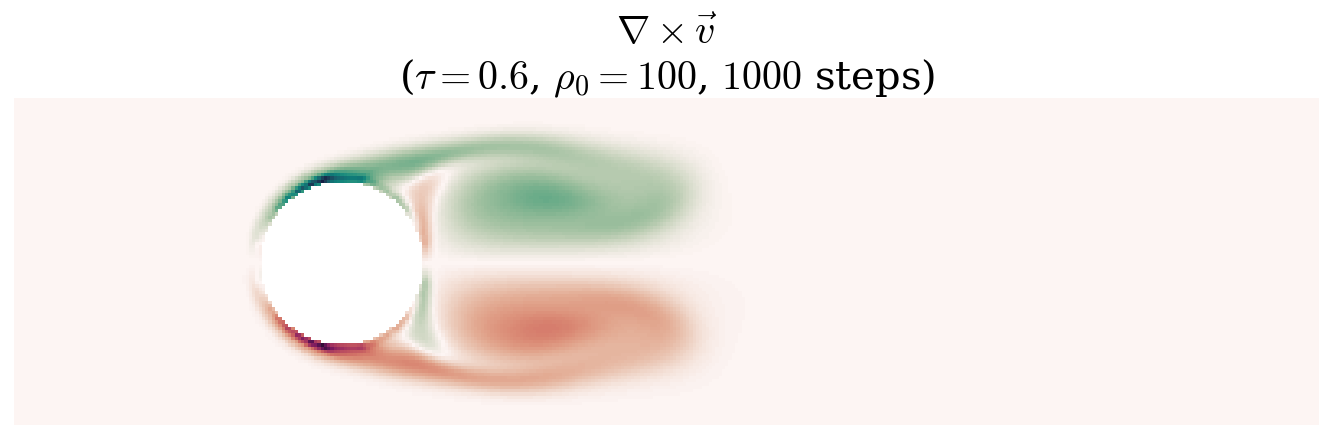

In [3]:
# Simulation Parameters
Nx, Ny = 400, 100
ρ0 = 100
τ = 0.6
steps = 1000

# Lattice speeds/weights
N_L  = 9
id_L = np.arange(N_L)
cx_L = np.array([0, 0, 1, 1,  1,  0, -1, -1, -1])
cy_L = np.array([0, 1, 1, 0, -1, -1, -1,  0,  1])
weights = np.array([4/9] + [1/9, 1/36]*4)

# Initial conditions
lattice_shape = (Ny, Nx, N_L)
X, Y = np.meshgrid(range(Nx), range(Ny))

np.random.seed(42)
F = np.ones(lattice_shape) + 0.01*np.random.randn(*lattice_shape)
F[:,:,3] += 2 * (1. + np.cos(8*pi*X/Nx)/5)
ρ = np.sum(F, axis = 2)
for i in id_L:
    F[:,:,i] *= ρ0/ρ

cylinder = (X - Nx/4)**2 + (Y - Ny/2)**2 < (Ny/4)**2

omega = np.zeros((steps, Ny, Nx))

for t_step in range(steps):
    # Drift
    for i, cx, cy in zip(id_L, cx_L, cy_L):
        F[:,:,i] = np.roll(F[:,:,i], (cx,cy), (1,0))
    
    # Set reflective boundaries
    F_refl = F[cylinder,:]
    F_refl = F_refl[:,[0, 5, 6, 7, 8, 1, 2, 3, 4]]
    
    # Calculate fluid variables
    ρ = np.sum(F, 2)
    ux = np.sum(F*cx_L, 2)/ρ
    uy = np.sum(F*cy_L, 2)/ρ
    
    # Apply collision
    F_eq = np.zeros(F.shape)
    for i, cx, cy, w in zip(id_L, cx_L, cy_L, weights):
        c_dot_u = cx*ux + cy*uy
        u_dot_u = ux*ux + uy*uy
        F_eq[:,:,i] = ρ * w * (1 + 3.0 * (c_dot_u) + 4.5 * (c_dot_u)**2 - 1.5 * (u_dot_u))
    F += -(1.0/τ) * (F - F_eq)
    
    F[cylinder,:] = F_refl
    ux[cylinder] = 0
    uy[cylinder] = 0
    
    # Calculate vorticity
    vorticity = (np.roll(ux,-1,0) - np.roll(ux,1,0)) - (np.roll(uy,-1,1) - np.roll(uy,1,1))
    vorticity[cylinder] = np.nan
    vorticity = np.ma.array(vorticity, mask = cylinder)
    
    omega[t_step] = vorticity

cmo_map = cmo.cm.curl
%matplotlib inline                  
%config InlineBackend.figure_format = 'retina'
fig, ax = plt.subplots(1,1, figsize = (12,12*(Ny/Nx)))
lattice = ax.imshow(omega[-1], cmap = cmo_map)
ax.set_title(r'$\nabla\times\vec{{v}}$' +'\n'+ r'($\tau = {}$, $\rho_{{0}} = {}$, ${}$ steps)'.format(τ, ρ0, steps))
ax.set_aspect('equal')
ax.axis(False)
plt.show()

In [6]:
%config InlineBackend.figure_format = 'retina'

fig, ax = plt.subplots(1,1, figsize = (12,12*(Ny/Nx)))
cmap = cmo.cm.curl
lattice = ax.imshow(omega[0], cmap = cmap, vmin = -0.15, vmax = 0.15)
ax.set_aspect('equal')
ax.axis(False)

def animate(i):
    lattice.set_array(omega[i])
fig.tight_layout()
plt.close()

fps = 30
n_fr = int(600)
anim = FuncAnimation(fig, animate, interval = int(1e3/fps), frames = np.arange(0, steps, int(steps/n_fr)), repeat = False)

In [7]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
writer_mp4 = animation.FFMpegWriter(fps = fps, extra_args = ['-vcodec', 'libx264'])
anim.save('vorticity_LB_{}_{}_{}.mp4'.format(steps, τ, ρ0), writer = writer_mp4, dpi = 250)

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
writer_gif = animation.PillowWriter(fps = fps)
anim.save('vorticity_LB_{}_{}_{}.gif'.format(steps, τ, ρ0), writer = writer_gif, dpi = 250)